In [1]:
%load_ext autoreload
%autoreload 2

from pybasilica import run
from pybasilica import svi
import pandas as pd 
import numpy as np
import seaborn as sns
import torch
import pyro
from sklearn.metrics import rand_score, mutual_info_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity 

/Users/elenab/Library/r-miniconda-arm64/envs/signatures/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = "../simbasilica/script_test/simul.N100.G5.s23"
data = pd.read_csv(file+"_counts.csv", sep=',')
groups_true = [i-1 for i in data["groups"].values]
data = data.drop(columns=["groups"])
N = data.shape[0] 

In [3]:
beta_fixed_true = ["SBS10b", "SBS1","SBS5","SBS22","SBS12","SBS3"]
beta_denovo_true = ["SBS2", "SBS4", "SBS25", "SBS44", "SBS9", "SBS13", "SBS88"]
k_fixed_true = len(beta_fixed_true)
k_denovo_true = len(beta_denovo_true)

alpha_true = pd.read_csv(file+"_alpha.csv", sep=",")
alpha_true = alpha_true[beta_fixed_true+beta_denovo_true]

In [4]:
catalogue = pd.read_csv("../simbasilica/script_test/COSMIC_v3.3.1_SBS_GRCh38.txt", sep="\t", index_col=0).transpose()

catalogue_fixed = catalogue.loc[beta_fixed_true]
catalogue_denovo = catalogue.loc[beta_denovo_true]

In [5]:
def get_cosine(obj, filt=True):
    beta_est = pd.concat((obj.beta_denovo, obj.beta_fixed))
    beta_est = beta_est.rename(index = lambda x: x + "_E")

    out_cosine = cosine_similarity(np.concatenate((beta_est, catalogue_denovo, catalogue_fixed)))
    names = list(beta_est.index) + beta_denovo_true + beta_fixed_true
    out_cosine = pd.DataFrame(out_cosine, index=names, columns=names) 
    
    if filt:
        out_cosine = out_cosine.loc[list(beta_est.index)][beta_fixed_true+beta_denovo_true]
    
    return out_cosine

In [6]:
def plot_cosine(obj, filt=True): 
    out_cosine = get_cosine(obj, filt=filt)
    
    sns.heatmap(out_cosine, vmin=0., vmax=1., cmap="crest") 

## Run with known groups

In [7]:
x1a = run.fit(data, k_list=k_denovo_true+k_fixed_true, verbose=False) 
x1b = run.fit(data, k_list=k_denovo_true+k_fixed_true, groups=groups_true, verbose=False) 

In [34]:
cosine = get_cosine(x1a)

In [40]:
print(cosine.idxmax())
print(cosine.transpose().idxmax())

SBS10b     D2_E
SBS1      D10_E
SBS5       D4_E
SBS22      D5_E
SBS12     D11_E
SBS3       D9_E
SBS2      D13_E
SBS4       D7_E
SBS25      D6_E
SBS44      D8_E
SBS9       D6_E
SBS13      D3_E
SBS88      D6_E
dtype: object
D1_E     SBS10b
D2_E     SBS10b
D3_E      SBS13
D4_E       SBS5
D5_E      SBS22
D6_E      SBS25
D7_E       SBS4
D8_E       SBS5
D9_E       SBS3
D10_E      SBS1
D11_E     SBS12
D12_E    SBS10b
D13_E      SBS2
dtype: object


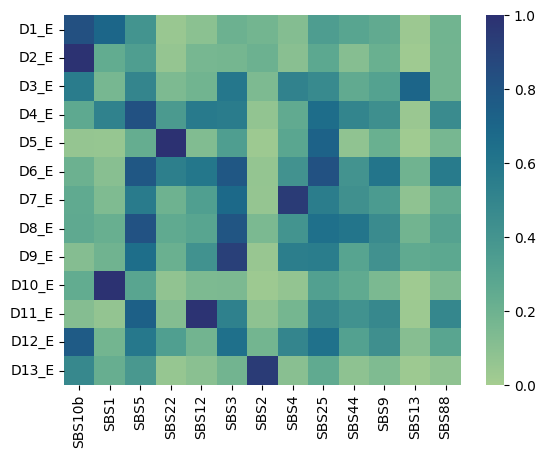

In [41]:
plot_cosine(x1a, filt=True) 

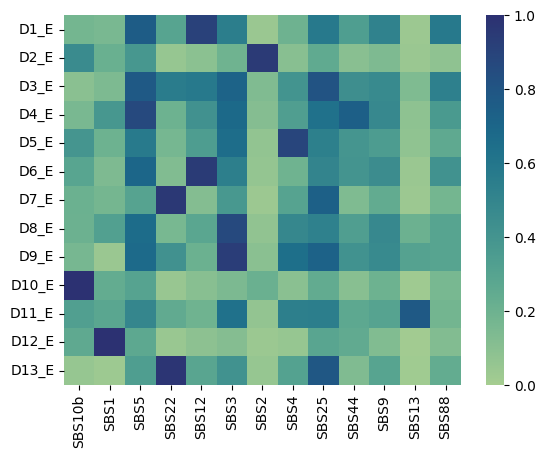

In [9]:
plot_cosine(x1b)

## Run with known groups and fixed catalogue

In [10]:
x2a = run.fit(data, k_list=k_denovo_true, beta_fixed=catalogue_fixed, verbose=False) 
x2b = run.fit(data, k_list=k_denovo_true, groups=groups_true, beta_fixed=catalogue_fixed, verbose=False) 

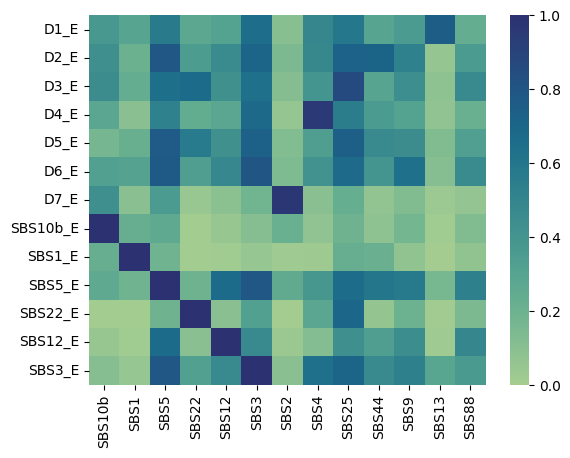

In [11]:
plot_cosine(x2a) 

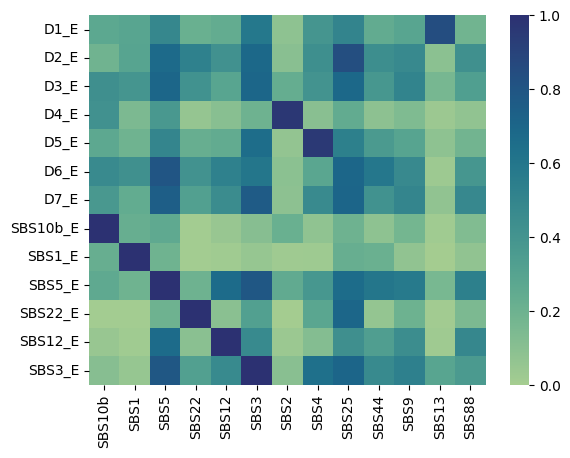

In [12]:
plot_cosine(x2b)

In [13]:
kl = torch.zeros(N)
for i in range(N):
    kl[i] = torch.nn.functional.kl_div(torch.tensor(alpha_true.values)[i], x2b.alpha[i])

## Run with latent groups

In [14]:
x3 = run.fit(data, k_list=k_denovo_true, cluster=5, beta_fixed=catalogue_fixed, enumer=False, verbose=False) 

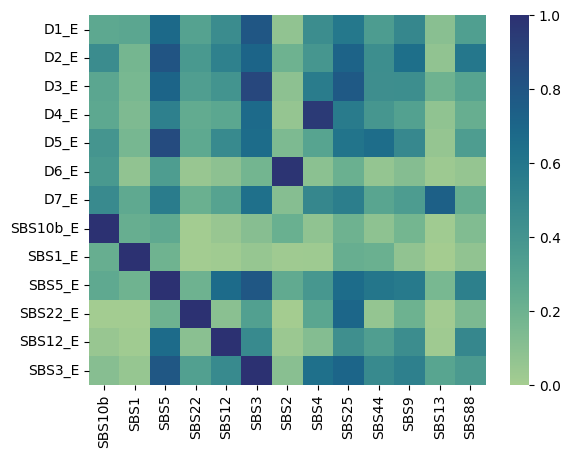

In [15]:
plot_cosine(x3) 

In [16]:
print(rand_score(groups_true, x3.z.detach().numpy()))
print(mutual_info_score(groups_true, x3.z.detach().numpy()))
print(normalized_mutual_info_score(groups_true, x3.z.detach().numpy())) 

0.6737373737373737
0.045398154033800556
0.028546281567226252


## Run with full enumeration

In [29]:
x4 = run.fit(data, k_list=k_denovo_true, cluster=5, enumer=True, verbose=False, beta_fixed=catalogue_fixed) 

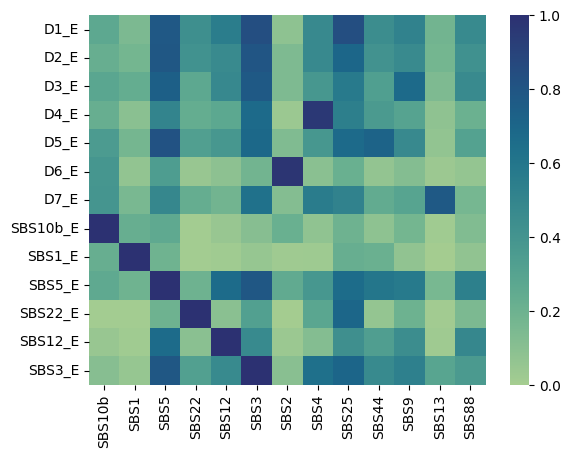

In [30]:
plot_cosine(x4) 

In [19]:
alpha = x4.alpha 
alpha_prior = x4.alpha_prior
beta_d = x4.beta_denovo
beta_f = x4.beta_fixed 

In [20]:
M = torch.tensor(x4.x.values)
cluster = x4.cluster
n_samples = x4.n_samples
pi = x4.pi
alpha_prior = x4.alpha_prior / (torch.sum(x4.alpha_prior, 1).unsqueeze(-1))
try:
    beta = torch.cat((torch.tensor(x4.beta_fixed.values), torch.tensor(x4.beta_denovo.values)), axis=0) 
except:
    beta = torch.tensor(x4.beta_denovo.values)

In [21]:
alpha_prior.sum(axis=1) 

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [23]:
def _logsumexp(weighted_lp) -> torch.Tensor:
    '''
    Returns `m + log( sum( exp( weighted_lp - m ) ) )`
    - `m` is the the maximum value of weighted_lp for each observation among the K values
    - `torch.exp(weighted_lp - m)` to perform some sort of normalization
    In this way the `exp` for the maximum value will be exp(0)=1, while for the 
    others will be lower than 1, thus the sum across the K components will sum up to 1.
    '''
    m = torch.amax(weighted_lp, dim=0)  # the maximum value for each observation among the K values
    summed_lk = m + torch.log(torch.sum(torch.exp(weighted_lp - m), axis=0))
    return summed_lk 

In [31]:
z = torch.zeros(n_samples)

for n in range(n_samples):
    m_n = M[n,:].unsqueeze(0)
    ll_nk = torch.zeros((cluster, M.shape[1]))

    for k in range(cluster):
        # compute weighted log probability
        ll_nk[k,:] = torch.log(pi[k]) + pyro.distributions.Poisson(torch.matmul( torch.matmul( torch.diag(torch.sum(m_n, axis=1).float()), alpha_prior[k,:].clone().detach().unsqueeze(0) ), beta.float() )).log_prob(m_n) 

    ll_nk_sum = ll_nk.sum(axis=1)
    ll = _logsumexp(ll_nk_sum)
    probs = torch.exp(ll_nk_sum - ll)

    best_cl = torch.argmax(probs)
    z[n] = best_cl 

In [32]:
z.unique()

tensor([0., 1., 2., 3., 4.])

In [33]:
print(rand_score(groups_true, z))
print(normalized_mutual_info_score(groups_true, z)) 

0.6854545454545454
0.32428151575364766
